In [1]:
from pathlib import Path

def find_project_root(start: Path) -> Path:
    p = start.resolve()
    for parent in [p] + list(p.parents):
        if (parent / "data").exists():
            return parent
    return p

ROOT = find_project_root(Path.cwd())

ROOT

WindowsPath('C:/Users/HiWi/Desktop/Terril/01_nextcloud/Germany/DATA SCIENCE/Semesters/05/02 Sustainability in aviation/03 contrail-mvp')

Matplotlib is building the font cache; this may take a moment.


BASE_DIR: C:\Users\HiWi\Desktop\Terril\01_nextcloud\Germany\DATA SCIENCE\Semesters\05\02 Sustainability in aviation\03 contrail-mvp\data\processed\scores\states_europe\2025-01-13_2025-01-14
Found flight score files: ['flight_scores_rhi_issr.parquet', 'flight_scores_rhi_issr.parquet', 'flight_scores_top2pct.parquet']
Found segment files: ['segments_with_era5_rhi_issr.parquet', 'segments_with_era5_rhi_issr.parquet', 'segments_with_era5_rhi_issr.parquet']
Loaded fs: (19986, 6) from flight_scores_rhi_issr.parquet
Loaded seg: (1336164, 19) from segments_with_era5_rhi_issr.parquet


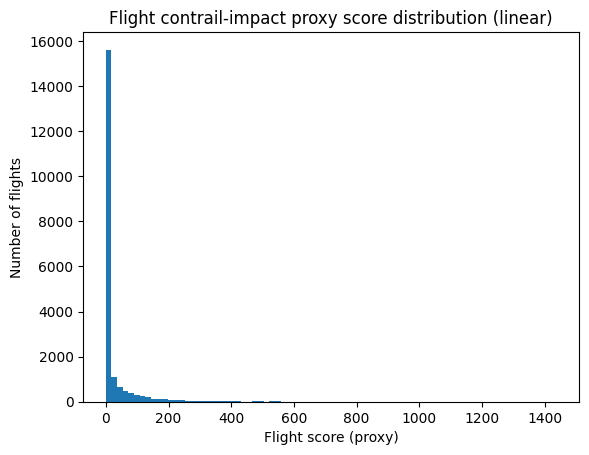

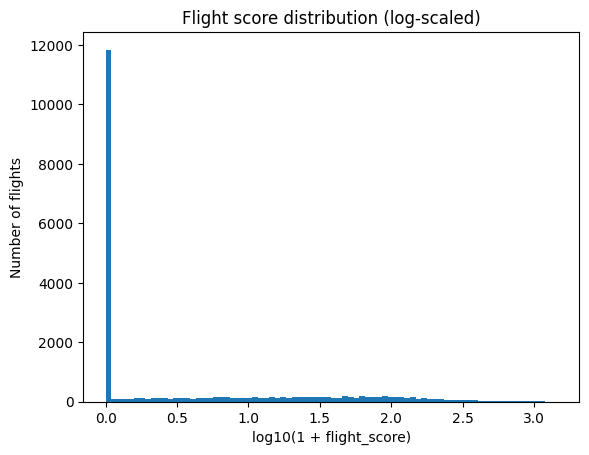

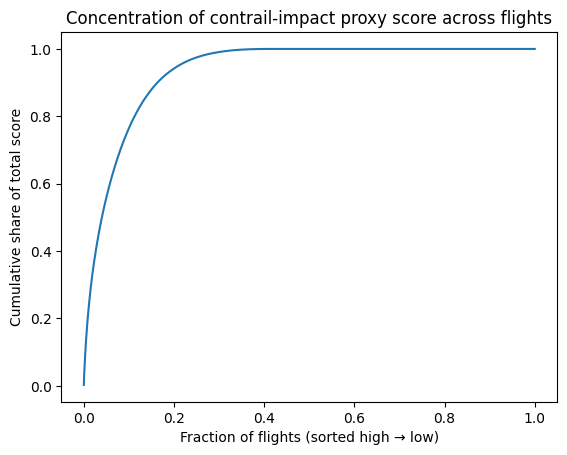

Top 2% flights (400) share of total score: 34.14%


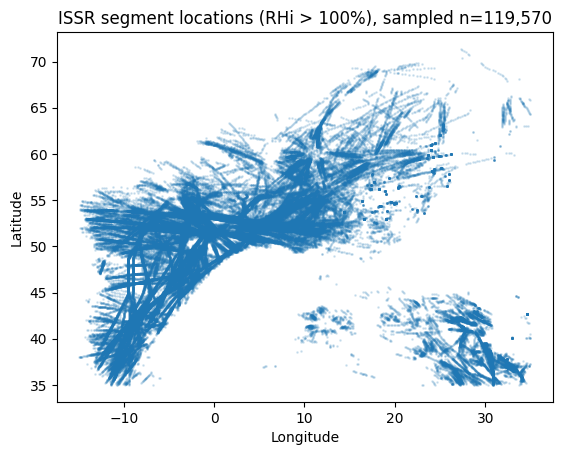

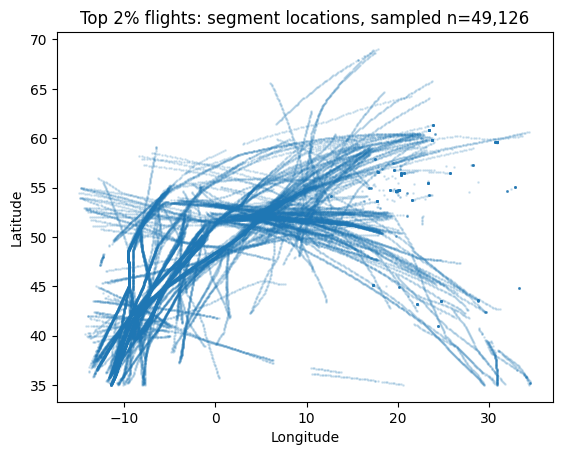

In [2]:
# --- Visualizations for contrail score project ---

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) SET THIS to your folder that contains the saved parquet outputs
BASE_DIR = ROOT /"data/processed/scores/states_europe/2025-01-13_2025-01-14"

# 2) Auto-find files (adjust patterns if your names differ)
fs_candidates = (
    list(BASE_DIR.glob("*flight_scores*issr*.parquet")) +
    list(BASE_DIR.glob("*flight_scores*.parquet"))
)
seg_candidates = (
    list(BASE_DIR.glob("*segments*issr*.parquet")) +
    list(BASE_DIR.glob("*segments*era5*.parquet")) +
    list(BASE_DIR.glob("*segments*.parquet"))
)

print("BASE_DIR:", BASE_DIR)
print("Found flight score files:", [p.name for p in fs_candidates])
print("Found segment files:", [p.name for p in seg_candidates])

if not fs_candidates or not seg_candidates:
    raise FileNotFoundError("Could not find flight_scores / segments parquet. Check BASE_DIR and filenames.")

FS_PATH = fs_candidates[0]
SEG_PATH = seg_candidates[0]

fs = pd.read_parquet(FS_PATH)
seg = pd.read_parquet(SEG_PATH)

print("Loaded fs:", fs.shape, "from", FS_PATH.name)
print("Loaded seg:", seg.shape, "from", SEG_PATH.name)

# ---------- Plot 1: Flight score histogram (linear) ----------
plt.figure()
plt.hist(fs["flight_score"].astype(float), bins=80)
plt.xlabel("Flight score (proxy)")
plt.ylabel("Number of flights")
plt.title("Flight contrail-impact proxy score distribution (linear)")
plt.show()

# ---------- Plot 2: Flight score histogram (log scale via log10(1+score)) ----------
scores = fs["flight_score"].astype(float).to_numpy()
logx = np.log10(1.0 + np.clip(scores, 0, None))

plt.figure()
plt.hist(logx, bins=80)
plt.xlabel("log10(1 + flight_score)")
plt.ylabel("Number of flights")
plt.title("Flight score distribution (log-scaled)")
plt.show()

# ---------- Plot 3: Concentration curve (cumulative share of total score) ----------
fs_sorted = fs.sort_values("flight_score", ascending=False).reset_index(drop=True)
cum = fs_sorted["flight_score"].astype(float).cumsum()
total = float(fs_sorted["flight_score"].astype(float).sum())
cum_share = (cum / total) if total > 0 else cum

x = (fs_sorted.index.to_numpy() + 1) / len(fs_sorted)

plt.figure()
plt.plot(x, cum_share.to_numpy())
plt.xlabel("Fraction of flights (sorted high → low)")
plt.ylabel("Cumulative share of total score")
plt.title("Concentration of contrail-impact proxy score across flights")
plt.show()

# Print your key headline metric
top_n = max(1, int(round(len(fs) * 0.02)))
top_share = fs_sorted.head(top_n)["flight_score"].sum() / fs_sorted["flight_score"].sum()
print(f"Top 2% flights ({top_n}) share of total score: {float(top_share):.2%}")

# ---------- Plot 4: ISSR segment map (sampled) ----------
# requires columns: mid_lat, mid_lon, ISSR
for col in ["mid_lat", "mid_lon", "ISSR"]:
    if col not in seg.columns:
        raise ValueError(f"Segments parquet is missing column '{col}'. Available: {list(seg.columns)}")

issr = seg[seg["ISSR"] == True]
n_sample = min(300_000, len(issr))
if n_sample > 0:
    issr_s = issr.sample(n=n_sample, random_state=1)
    plt.figure()
    plt.scatter(issr_s["mid_lon"], issr_s["mid_lat"], s=1, alpha=0.15)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"ISSR segment locations (RHi > 100%), sampled n={n_sample:,}")
    plt.show()
else:
    print("No ISSR segments found to plot.")

# ---------- Plot 5: Top-2% flight segment map (sampled) ----------
if "flight_id" not in seg.columns:
    raise ValueError("Segments parquet missing 'flight_id' column.")

top_ids = set(fs_sorted.head(top_n)["flight_id"].astype(str))
seg_top = seg[seg["flight_id"].astype(str).isin(top_ids)]
n_sample_top = min(300_000, len(seg_top))
if n_sample_top > 0:
    seg_top_s = seg_top.sample(n=n_sample_top, random_state=2)
    plt.figure()
    plt.scatter(seg_top_s["mid_lon"], seg_top_s["mid_lat"], s=1, alpha=0.15)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Top 2% flights: segment locations, sampled n={n_sample_top:,}")
    plt.show()
else:
    print("No top-2% segments found to plot.")


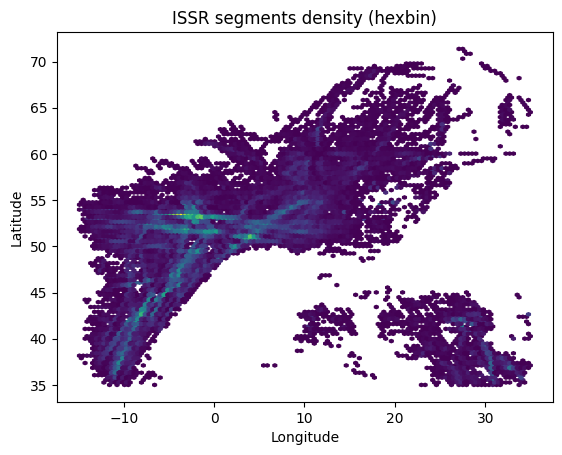

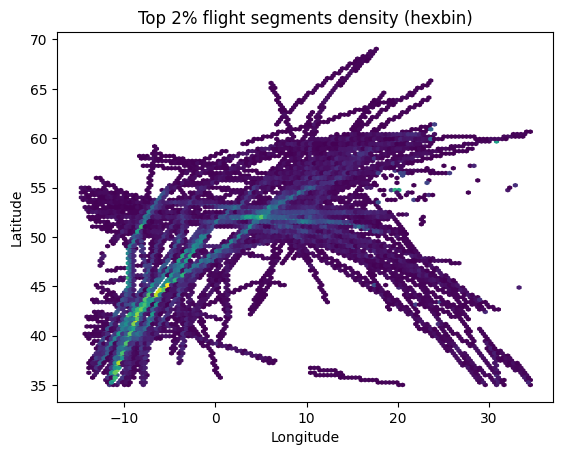

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# seg = segments_with_era5_rhi_issr dataframe
# fs = flight_scores dataframe

# Top 2% IDs
fs_sorted = fs.sort_values("flight_score", ascending=False)
top_n = max(1, int(round(len(fs_sorted) * 0.02)))
top_ids = set(fs_sorted.head(top_n)["flight_id"].astype(str))

seg["flight_id"] = seg["flight_id"].astype(str)
seg_top = seg[seg["flight_id"].isin(top_ids)]
seg_issr = seg[seg["ISSR"] == True]

# 1) ISSR density
plt.figure()
plt.hexbin(seg_issr["mid_lon"], seg_issr["mid_lat"], gridsize=120, mincnt=1)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("ISSR segments density (hexbin)")
plt.show()

# 2) Top 2% density
plt.figure()
plt.hexbin(seg_top["mid_lon"], seg_top["mid_lat"], gridsize=120, mincnt=1)
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("Top 2% flight segments density (hexbin)")
plt.show()


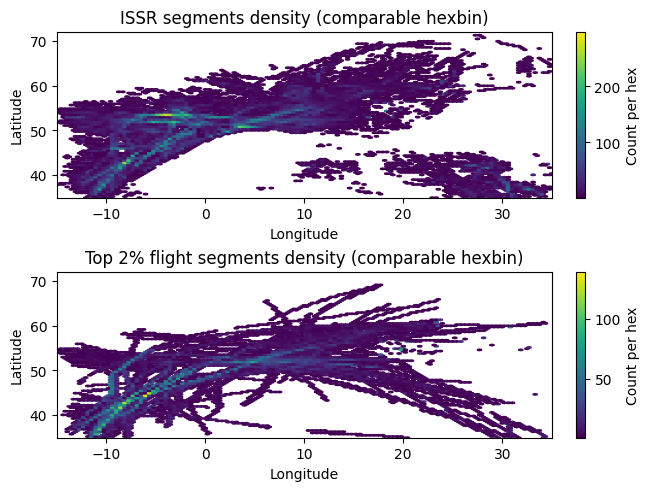

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Top 2% flight IDs
fs_sorted = fs.sort_values("flight_score", ascending=False).reset_index(drop=True)
top_n = max(1, int(round(len(fs_sorted) * 0.02)))
top_ids = set(fs_sorted.head(top_n)["flight_id"].astype(str))

seg = seg.copy()
seg["flight_id"] = seg["flight_id"].astype(str)

seg_top  = seg[seg["flight_id"].isin(top_ids)]
seg_issr = seg[seg["ISSR"] == True]

# Common extent + grid
xlim = (-15, 35)
ylim = (35, 72)
gridsize = 120

fig, axes = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

hb1 = axes[0].hexbin(seg_issr["mid_lon"], seg_issr["mid_lat"],
                    gridsize=gridsize, mincnt=1,
                    extent=(xlim[0], xlim[1], ylim[0], ylim[1]))
axes[0].set_xlim(*xlim); axes[0].set_ylim(*ylim)
axes[0].set_xlabel("Longitude"); axes[0].set_ylabel("Latitude")
axes[0].set_title("ISSR segments density (comparable hexbin)")
plt.colorbar(hb1, ax=axes[0], label="Count per hex")

hb2 = axes[1].hexbin(seg_top["mid_lon"], seg_top["mid_lat"],
                    gridsize=gridsize, mincnt=1,
                    extent=(xlim[0], xlim[1], ylim[0], ylim[1]))
axes[1].set_xlim(*xlim); axes[1].set_ylim(*ylim)
axes[1].set_xlabel("Longitude"); axes[1].set_ylabel("Latitude")
axes[1].set_title("Top 2% flight segments density (comparable hexbin)")
plt.colorbar(hb2, ax=axes[1], label="Count per hex")

plt.show()


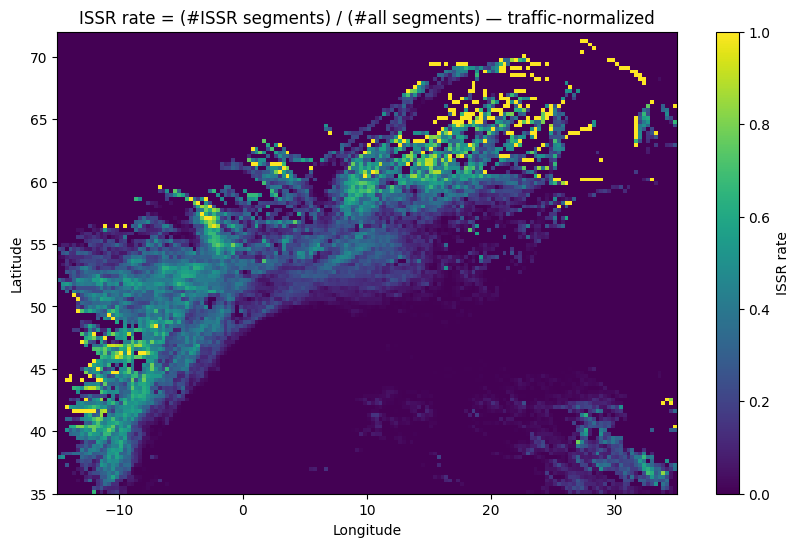

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Use the same bounds as above
xlim = (-15, 35)
ylim = (35, 72)

# Grid resolution (higher = more detail, slower)
nx, ny = 160, 120
lon_edges = np.linspace(xlim[0], xlim[1], nx + 1)
lat_edges = np.linspace(ylim[0], ylim[1], ny + 1)

def bin_counts(df):
    ix = np.digitize(df["mid_lon"].to_numpy(), lon_edges) - 1
    iy = np.digitize(df["mid_lat"].to_numpy(), lat_edges) - 1
    mask = (ix >= 0) & (ix < nx) & (iy >= 0) & (iy < ny)
    ix, iy = ix[mask], iy[mask]
    counts = np.zeros((ny, nx), dtype=np.int32)
    np.add.at(counts, (iy, ix), 1)
    return counts

counts_all  = bin_counts(seg)
counts_issr = bin_counts(seg[seg["ISSR"] == True])

issr_rate = np.divide(counts_issr, counts_all,
                      out=np.zeros_like(counts_issr, dtype=float),
                      where=counts_all > 0)

plt.figure(figsize=(10, 6))
plt.imshow(issr_rate, origin="lower",
           extent=(xlim[0], xlim[1], ylim[0], ylim[1]),
           aspect="auto")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("ISSR rate = (#ISSR segments) / (#all segments) — traffic-normalized")
plt.colorbar(label="ISSR rate")
plt.show()


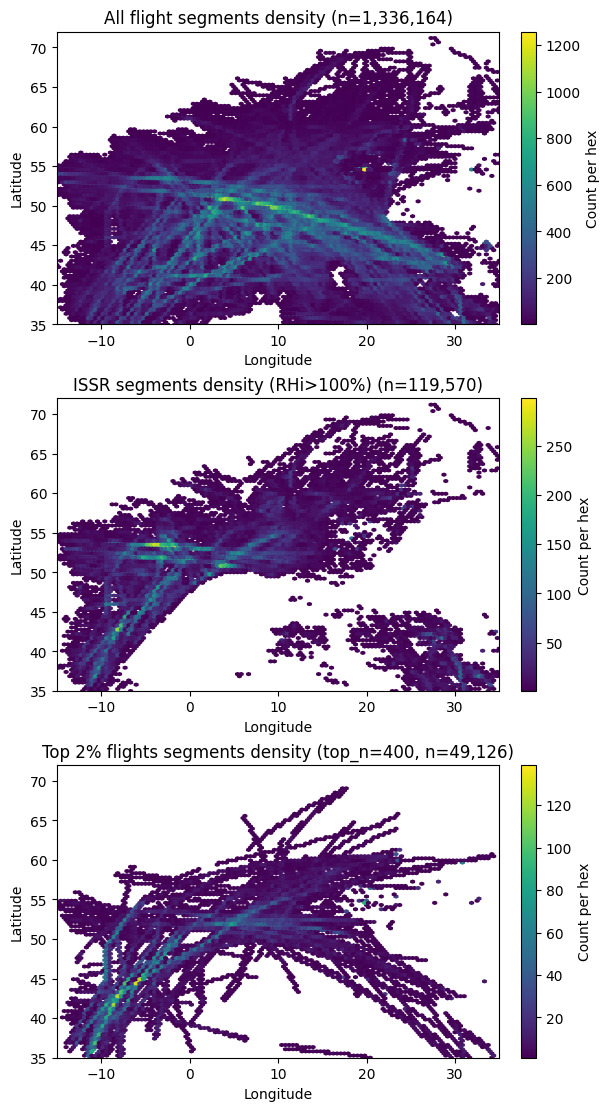

Top 2% share of total score: 34.14%
Zero-score flights: 58.7%


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- Assume you already have these loaded ---
# seg = segments_with_era5_rhi_issr dataframe
# fs  = flight_scores dataframe

# Top 2% flight IDs
fs_sorted = fs.sort_values("flight_score", ascending=False).reset_index(drop=True)
top_n = max(1, int(round(len(fs_sorted) * 0.02)))
top_ids = set(fs_sorted.head(top_n)["flight_id"].astype(str))

seg = seg.copy()
seg["flight_id"] = seg["flight_id"].astype(str)

seg_all  = seg
seg_issr = seg[seg["ISSR"] == True]
seg_top  = seg[seg["flight_id"].isin(top_ids)]

# --- Common plot settings for comparability ---
xlim = (-15, 35)
ylim = (35, 72)
gridsize = 120
extent = (xlim[0], xlim[1], ylim[0], ylim[1])

def hexplot(ax, df, title):
    hb = ax.hexbin(df["mid_lon"], df["mid_lat"],
                   gridsize=gridsize, mincnt=1, extent=extent)
    ax.set_xlim(*xlim); ax.set_ylim(*ylim)
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    ax.set_title(title)
    return hb

fig, axes = plt.subplots(3, 1, figsize=(6, 11), constrained_layout=True)

hb0 = hexplot(axes[0], seg_all,  f"All flight segments density (n={len(seg_all):,})")
plt.colorbar(hb0, ax=axes[0], label="Count per hex")

hb1 = hexplot(axes[1], seg_issr, f"ISSR segments density (RHi>100%) (n={len(seg_issr):,})")
plt.colorbar(hb1, ax=axes[1], label="Count per hex")

hb2 = hexplot(axes[2], seg_top,  f"Top 2% flights segments density (top_n={top_n:,}, n={len(seg_top):,})")
plt.colorbar(hb2, ax=axes[2], label="Count per hex")

plt.show()

# Headline metrics (nice to print)
total_score = fs_sorted["flight_score"].sum()
top_score = fs_sorted.head(top_n)["flight_score"].sum()
print(f"Top 2% share of total score: {float(top_score/total_score):.2%}" if total_score > 0 else "Total score is 0")
print(f"Zero-score flights: {(fs_sorted['flight_score']==0).mean():.1%}")


# What smallest fraction of flights accounts for 80% of the total score?|

In [11]:
import pandas as pd
import numpy as np

# Load your scores (or use the fs dataframe you already have)
# fs = pd.read_parquet(".../flight_scores_rhi_issr.parquet")

fs_sorted = fs.sort_values("flight_score", ascending=False).reset_index(drop=True)

scores = fs_sorted["flight_score"].astype(float).to_numpy()
total = scores.sum()

if total <= 0:
    print("Total score is 0. Can't compute shares.")
else:
    cum_share = np.cumsum(scores) / total
    
    # Find the first index where cumulative share reaches 80%
    idx = int(np.searchsorted(cum_share, 0.80, side="left"))
    
    flights_needed = idx + 1
    pct_flights = flights_needed / len(fs_sorted) * 100
    
    print(f"Flights total: {len(fs_sorted):,}")
    print(f"Flights needed for 80% of total score: {flights_needed:,}")
    print(f"Percentage of flights causing 80% of total score: {pct_flights:.2f}%")
    print(f"(Check) cumulative share at that point: {cum_share[idx]:.3f}")


Flights total: 19,986
Flights needed for 80% of total score: 2,250
Percentage of flights causing 80% of total score: 11.26%
(Check) cumulative share at that point: 0.800
